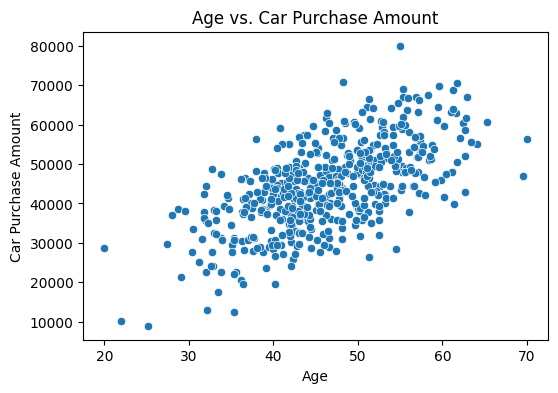

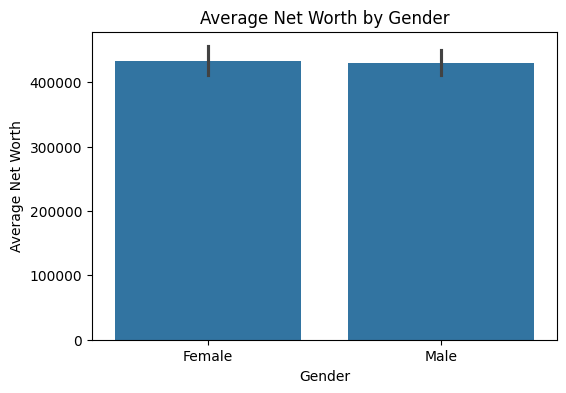

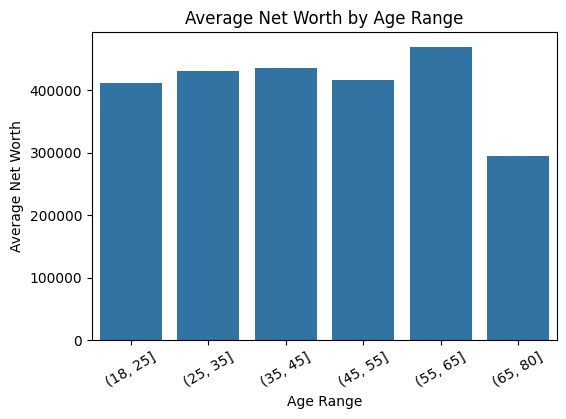

## Car Finder Tool – Fill out your details

FloatText(value=0.0, description='Age:', layout=Layout(width='500px'))

FloatText(value=0.0, description='Salary:', layout=Layout(width='500px'))

FloatText(value=0.0, description='Net Worth:', layout=Layout(width='500px'))

Dropdown(description='Type:', layout=Layout(width='500px'), options=('SUV', 'Sedan', 'Coupe', 'Pickup', 'Conve…

FloatText(value=0.0, description='Min MPG:', layout=Layout(width='500px'))

Button(description='Find Cars', style=ButtonStyle())

Output()

In [6]:
!pip install -q pandas scikit-learn matplotlib seaborn ipywidgets

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LinearRegression
from google.colab import files
import ipywidgets as widgets
from IPython.display import display, Markdown

# Upload datasets manually if they don't exist
if not os.path.isfile("car_purchasing[1].csv"):
    print("Upload the 'car_purchasing[1].csv' file...")
    files.upload()

if not os.path.isfile("extended_data[1].csv"):
    print("Upload the 'extended_data[1].csv' file...")
    files.upload()

# Load car dataset and clean it up
try:
    car_data = pd.read_csv("extended_data[1].csv").drop_duplicates()
except Exception as e:
    print("Trouble loading car data:", e)
    car_data = pd.DataFrame()

# Display graphs after cleaning but before widgets
try:
    purchase_data = pd.read_csv("car_purchasing[1].csv", encoding="ISO-8859-1")

    # Map gender values
    purchase_data["gender"] = purchase_data["gender"].map({0: "Female", 1: "Male"})

    # 1. Scatter plot - Age vs. Car Purchase Amount
    plt.figure(figsize=(6,4))
    sns.scatterplot(x="age", y="car purchase amount", data=purchase_data)
    plt.title("Age vs. Car Purchase Amount")
    plt.xlabel("Age")
    plt.ylabel("Car Purchase Amount")
    plt.show()

    # 2. Bar graph - Gender vs. Net Worth
    plt.figure(figsize=(6,4))
    sns.barplot(x="gender", y="net worth", data=purchase_data, estimator="mean")
    plt.title("Average Net Worth by Gender")
    plt.xlabel("Gender")
    plt.ylabel("Average Net Worth")
    plt.show()

    # 3. Bar graph - Age Ranges vs. Net Worth
    age_bins = [18, 25, 35, 45, 55, 65, 80]
    purchase_data["age_range"] = pd.cut(purchase_data["age"], bins=age_bins)
    age_networth = purchase_data.groupby("age_range", observed=False)["net worth"].mean().reset_index()

    plt.figure(figsize=(6,4))
    sns.barplot(x="age_range", y="net worth", data=age_networth)
    plt.title("Average Net Worth by Age Range")
    plt.xlabel("Age Range")
    plt.ylabel("Average Net Worth")
    plt.xticks(rotation=30)
    plt.show()

except Exception as e:
    print("Error generating graphs:", e)

# Quick sanity check – these are the categories we're filtering by
car_types = ["SUV", "Sedan", "Coupe", "Pickup", "Convertible"]

# Simple model using basic financial data to predict car budget
def train_model():
    df = pd.read_csv("car_purchasing[1].csv", encoding="ISO-8859-1")
    features = ["age", "annual Salary", "net worth"]
    X = df[features]
    y = df["car purchase amount"]

    model = LinearRegression()
    model.fit(X, y)
    return model

# Just making sure our car data has what we expect
def check_columns(df):
    needed = {"msrp", "type", "miles_per_gallon", "model"}
    if not needed.issubset(df.columns):
        raise Exception(f"Missing columns: {needed - set(df.columns)}")
    return df

# Recommend cars within ±$1000 of budget, matching type and mpg
def recommend_cars(model, df, age, salary, net_worth, car_type, mpg):
    input_df = pd.DataFrame([[age, salary, net_worth]], columns=["age", "annual Salary", "net worth"])
    prediction = model.predict(input_df)[0]
    budget_range = (prediction - 1000, prediction + 1000)

    filtered = df[
        (df["msrp"].between(*budget_range)) &
        (df["type"].str.lower() == car_type.lower()) &
        (df["miles_per_gallon"] >= mpg)
    ]

    print(f"\nYour estimated car budget is around: ${prediction:,.2f}")
    if filtered.empty:
        print("Sorry, no matching cars found with your criteria.")
    else:
        display(filtered[["model", "msrp", "type", "miles_per_gallon"]])

# Set up the form
layout = widgets.Layout(width='500px')
age = widgets.FloatText(description="Age:", layout=layout)
salary = widgets.FloatText(description="Salary:", layout=layout)
net = widgets.FloatText(description="Net Worth:", layout=layout)
car_type = widgets.Dropdown(options=car_types, description="Type:", layout=layout)
min_mpg = widgets.FloatText(description="Min MPG:", layout=layout)
submit_btn = widgets.Button(description="Find Cars")
results_output = widgets.Output()

display(Markdown("## Car Finder Tool – Fill out your details"))
display(age, salary, net, car_type, min_mpg, submit_btn, results_output)

# Handle button click
def on_submit(_):
    with results_output:
        results_output.clear_output()
        try:
            model = train_model()
            valid_data = check_columns(car_data.copy())
            recommend_cars(
                model, valid_data,
                age.value, salary.value, net.value,
                car_type.value, min_mpg.value
            )
        except Exception as err:
            print("Something went wrong:", err)

submit_btn.on_click(on_submit)
